In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the CSV file
metadata = pd.read_csv('ATEPP-metadata-1.1.csv')

# Filter data for compositions by Ludwig van Beethoven
beethoven_data = metadata[metadata['composer'] == 'Ludwig van Beethoven']

# Filter out necessary columns
filtered_metadata = beethoven_data[['artist', 'midi_path']]

# Get artist counts
artist_counts = filtered_metadata['artist'].value_counts()

# Identify the top 5 artists with the most records
top_artists = artist_counts.head(5).index

# Randomly select 300 records for each of the top artists
selected_data = filtered_metadata[filtered_metadata['artist'].isin(top_artists)]
sampled_data = selected_data.groupby('artist').apply(lambda x: x.sample(n=300, random_state=36)).reset_index(drop=True)

# Encode the 'artist' column
le = LabelEncoder()
sampled_data['artist_encoded'] = le.fit_transform(sampled_data['artist'])

# Split the data into training and testing sets
train_df, test_df = train_test_split(sampled_data, test_size=0.2, stratify=sampled_data['artist_encoded'], random_state=42)

# Reset the indices
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [2]:
import numpy as np
# Load the arrays
train_padded_piano_rolls = np.load('X_train_padded2.npy')
test_padded_piano_rolls = np.load('X_test_padded2.npy')
train_features = np.load('X_train_features4.npy')
test_features = np.load('X_test_features4.npy')

In [3]:
train_padded_piano_rolls = train_padded_piano_rolls / train_padded_piano_rolls.max(axis=(1, 2), keepdims=True)
test_padded_piano_rolls = test_padded_piano_rolls / test_padded_piano_rolls.max(axis=(1, 2), keepdims=True)

In [4]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
train_features = scaler.fit_transform(train_features)

# Use the same scaler to transform the test data
test_features = scaler.transform(test_features)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class MIDIDataset(Dataset):
    def __init__(self, piano_rolls, features, labels):
        self.piano_rolls = torch.tensor(piano_rolls).float()
        self.features = torch.tensor(features).float()
        self.labels = torch.tensor(labels).long()

    def __len__(self):
        return len(self.piano_rolls)

    def __getitem__(self, idx):
        return self.piano_rolls[idx].unsqueeze(0), self.features[idx], self.labels[idx]


train_dataset = MIDIDataset(train_padded_piano_rolls, train_features, train_df['artist_encoded'].values)
test_dataset = MIDIDataset(test_padded_piano_rolls, test_features, test_df['artist_encoded'].values)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=False)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class SimplifiedArtistIdentifier(nn.Module):
    def __init__(self, num_artists):
        super(SimplifiedArtistIdentifier, self).__init__()

        # Initial reshape using MaxPool2d
        self.initial_pool = nn.MaxPool2d(kernel_size=(10,5), stride=5)

        # CNN for piano rolls
        self.cnn = nn.Sequential(
            ResNetBlock(1, 32),
            ResNetBlock(32, 64, stride=2),
            ResNetBlock(64, 128, stride=2),
            ResNetBlock(128, 256, stride=2),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Simplified MLP for features
        self.mlp = nn.Sequential(
            nn.Linear(7, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU()
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256 + 256, 64),  # 256 from CNN, 256 from MLP
            nn.ReLU(),
            nn.Linear(64, num_artists)
        )

    def forward(self, piano_roll, features):
        piano_roll = self.initial_pool(piano_roll)
        
        piano_out = self.cnn(piano_roll)
        piano_out = piano_out.view(piano_out.size(0), -1)  # Flatten

        features_out = self.mlp(features)

        combined = torch.cat((piano_out, features_out), dim=1)
        out = self.classifier(combined)
        return out

In [7]:
num_artists = len(top_artists)
model = SimplifiedArtistIdentifier(num_artists)

In [8]:
# Define the loss function and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
# epochs 1-50 use lr 0.002, epochs 50-80 use lr 0.002*0.2, epochs 80-100 use lr 0.002*0.2*0.2
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.5) 

In [9]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if not device:
        device = next(iter(net.parameters())).device
    metric = mu.d2l.Accumulator(2)  # num_corrected_examples, num_examples
    for piano_rolls, features, y in data_iter:
        piano_rolls, features, y = piano_rolls.to(device), features.to(device), y.to(device)
        y_hat = net(piano_rolls, features)
        metric.add(mu.d2l.accuracy(y_hat, y), mu.d2l.size(y))
    return metric[0] / metric[1]


In [10]:
import my_utils as mu

def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        net.train()
        for i, (piano_rolls, features, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            piano_rolls, features, y = piano_rolls.to(device), features.to(device), y.to(device)
            y_hat = net(piano_rolls, features)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * piano_rolls.shape[0], mu.d2l.accuracy(y_hat, y), piano_rolls.shape[0])
            timer.stop()
        
        # Calculate average training loss and accuracy for the epoch
        train_loss, train_acc = metric[0] / metric[2], metric[1] / metric[2]
        
        scheduler.step() # dynamic adjust lr
        
        # Evaluate on test data
        test_acc = evaluate_accuracy_gpu(net, test_iter, device)  # Use the modified function
        
        # Update the animator
        animator.add(epoch + 1, (train_loss, train_acc, test_acc))
        
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.006, train acc 1.000, test acc 0.723
459.2 examples/sec on cuda


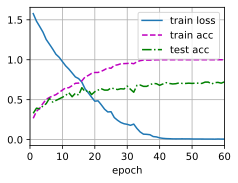

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu

# Train the model
num_epochs = 60
trainf(model, train_loader, test_loader, loss, num_epochs, optimizer, device)

In [13]:
model_path = "autodl-tmp/cnn+mlp-artist_id.pth"
torch.save(model.state_dict(), model_path)